# 推特抢跑 Notebook 验证（v0.1.1）

本 Notebook 用于验证：推文 → AI 分析 → 交易对推断 → Binance 1m K 线展示 的完整流程。

- 同时展示推文 UTC 时间与本地时间（UTC+8）。
- AI 分析结果采用多行 JSON 格式输出，便于人工检查。
- 提供 `run_analysis(page: int)` 统一入口，快速切换不同推文。

In [2]:
# 配置与依赖加载
import json
from datetime import datetime, timedelta
from typing import Dict, Any, Optional, List

import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from twitter_crawler_functional_min import ai_analyze_text, LOCAL_JSON_PATH

# Binance K 线配置
BINANCE_BASE_URL = "https://api.binance.com"
BINANCE_KLINES_PATH = "/api/v3/klines"
BINANCE_INTERVAL = "1m"
WINDOW_MINUTES = 15  # 推文时间前后各 15 分钟

# Notebook 默认页码（可在下方使用 run_analysis 覆盖）
TWEET_PAGE = 0  # 使用 latest.json 中的第几条推文（data["tweets"][page]）

In [3]:
def load_single_tweet(path: str, page: int) -> Dict[str, Any]:
    """从 latest.json 中读取指定 page 的单条推文。
    - 结构遵循需求：data["tweets"][page]
    - 若顶层不是 dict，而是 list，则直接用 list[page]
    """
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if isinstance(data, dict):
        tweets = data.get("tweets") or data
    else:
        tweets = data
    return tweets[page]


def parse_tweet_time(tweet: Dict[str, Any]) -> datetime:
    """将推文中的 createdAt 转为 UTC datetime 对象。
    示例格式："Thu Nov 13 16:25:19 +0000 2025"
    """
    created_at = tweet.get("createdAt") or tweet.get("created_at")
    return datetime.strptime(created_at, "%a %b %d %H:%M:%S %z %Y")


def to_local_time(dt_utc: datetime, offset_hours: int = 8) -> datetime:
    """将 UTC 时间转换为本地时间（默认 UTC+8）。"""
    return dt_utc + timedelta(hours=offset_hours)

In [4]:
def call_ai_for_tweet(text: str, use_proxy: Optional[bool] = None) -> Dict[str, Any]:
    """调用已有 ai_analyze_text，对推文文本做分析并尽量解析为 JSON dict。
    - use_proxy 为 None 时，沿用全局 USE_OPENAI_PROXY 行为
    - 若 AI 返回非严格 JSON，则包装为 {"raw": 原始字符串}
    """
    raw = ai_analyze_text(text, proxy=use_proxy)
    if not raw:
        return {"raw": "(空响应)"}
    try:
        return json.loads(raw)
    except Exception:
        return {"raw": raw}


def pretty_print_ai(ai_res: Dict[str, Any]) -> None:
    """人类友好的多行打印 AI 分析结果。"""
    if "raw" in ai_res and len(ai_res) == 1:
        print("[AI RAW]")
        print(ai_res["raw"])
        return
    try:
        print("[AI JSON]")
        print(json.dumps(ai_res, ensure_ascii=False, indent=2))
    except Exception:
        print("[AI RAW/FALLBACK]")
        print(ai_res)

In [5]:
SYMBOL_MAP = {
    "BTC": "BTCUSDT",
    "ETH": "ETHUSDT",
    "BNB": "BNBUSDT",
    "SOL": "SOLUSDT",
    "DOGE": "DOGEUSDT",
}


def normalize_symbol_from_ai(ai_res: Dict[str, Any]) -> Optional[str]:
    """从 AI 结果中提取交易币种并映射为 Binance 现货 symbol。"""
    raw_symbol = ai_res.get("交易币种")
    print(raw_symbol)
    if isinstance(raw_symbol, list) and raw_symbol:
        first = str(raw_symbol[0]).upper()
    elif isinstance(raw_symbol, str) and raw_symbol.strip():
        first = raw_symbol.strip().upper()
    else:
        return None
    base = first.replace("USDT", "").replace("/", "").upper()
    return base + "USDT"


def fallback_symbol_from_text(text: str) -> Optional[str]:
    """在 AI 无法给出交易币种时，从原始文本粗略匹配常见币种。"""
    upper = text.upper()
    for base, symbol in SYMBOL_MAP.items():
        if base in upper:
            return symbol
    return None


def detect_trade_symbol(ai_res: Dict[str, Any], text: str) -> Optional[str]:
    """综合 AI 输出与原始文本，推断最终可交易 symbol。
    - 优先 AI 输出
    - 其次文本关键词
    - 若仍无法确定，返回 None（视为不可交易）
    """
    symbol = normalize_symbol_from_ai(ai_res)
    return symbol


In [6]:
def fetch_binance_klines(symbol: str, center_time_utc: datetime,
                         minutes: int = WINDOW_MINUTES) -> List[List[Any]]:
    """获取 symbol 在 center_time 前后指定分钟窗口内的 1m K 线原始数据（使用 UTC 时间戳）。"""
    start = center_time_utc - timedelta(minutes=minutes)
    end = center_time_utc + timedelta(minutes=minutes)
    params = {
        "symbol": symbol.upper(),
        "interval": BINANCE_INTERVAL,
        "startTime": int(start.timestamp() * 1000),
        "endTime": int(end.timestamp() * 1000),
    }
    url = BINANCE_BASE_URL + BINANCE_KLINES_PATH
    resp = requests.get(url, params=params, timeout=10)
    resp.raise_for_status()
    return resp.json()


def format_klines(klines: List[List[Any]]):
    """将 Binance 原始 K 线转换为 (times, opens, highs, lows, closes)。
    times 使用本地时间（便于与本地 UTC+8 对齐）。
    """
    times, opens, highs, lows, closes = [], [], [], [], []
    for k in klines:
        ts = datetime.fromtimestamp(k[0] / 1000)
        times.append(ts)
        opens.append(float(k[1]))
        highs.append(float(k[2]))
        lows.append(float(k[3]))
        closes.append(float(k[4]))
    return times, opens, highs, lows, closes

In [7]:
def plot_candles(times, opens, highs, lows, closes,
                 tweet_time_local: datetime,
                 title: str = "",
                 tweet_time_utc: Optional[datetime] = None) -> None:
    """简单绘制 1m K 线并标出推文时间竖线。
    - X 轴：本地时间（通常为 UTC+8）
    - 图下方附加推文 UTC / 本地时间说明
    """
    fig, ax = plt.subplots(figsize=(10, 4))
    for t, o, h, l, c in zip(times, opens, highs, lows, closes):
        color = "red" if c >= o else "green"
        ax.plot([t, t], [l, h], color=color, linewidth=1)
        ax.plot([t, t], [o, c], color=color, linewidth=4)

    ax.axvline(tweet_time_local, color="blue",
               linestyle="--", label="Tweet Time")

    if times:
        min_t, max_t = min(times), max(times)
        ax.set_xlim(min_t, max_t)

    ax.set_title(title)
    ax.set_xlabel("Time (Local, UTC+8)")
    ax.set_ylabel("Price")

    locator = mdates.AutoDateLocator()
    formatter = mdates.DateFormatter("%m-%d %H:%M")
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    plt.legend()

    if tweet_time_utc is not None:
        info = (
            f"Tweet UTC: {tweet_time_utc.strftime('%Y-%m-%d %H:%M:%S %z')}\n" 
            f"Tweet Local (UTC+8): {tweet_time_local.strftime('%Y-%m-%d %H:%M:%S')}"
        )
        plt.figtext(0.01, -0.02, info, ha="left", va="top", fontsize=8)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [8]:
def run_analysis(page: int, json_path=None) -> None:
    """统一入口：分析 data["tweets"][page] 的完整链路。"""
    global TWEET_PAGE
    TWEET_PAGE = page
    print(f"[RUN] 分析 data['tweets'][{page}]")
    if not json_path:
        tweet = load_single_tweet(LOCAL_JSON_PATH, TWEET_PAGE)
    else:
        tweet = load_single_tweet(json_path, page)
    tweet_text = tweet.get("text") or tweet.get("full_text") or ""
    tweet_time_utc = parse_tweet_time(tweet)
    tweet_time_local = to_local_time(tweet_time_utc, 8)

    print("[TWEET ID   ]", tweet.get("id"))
    print("[CREATED UTC]", tweet.get("createdAt"))
    print("[CREATED CN ]", tweet_time_local.strftime("%Y-%m-%d %H:%M:%S (UTC+8)"))
    print("[TEXT       ]", tweet_text)

    ai_result = call_ai_for_tweet(tweet_text)
    pretty_print_ai(ai_result)

    base_symbol = detect_trade_symbol(ai_result, tweet_text)
    symbol = base_symbol

    direction = ai_result.get("交易方向") or ai_result.get("direction")
    confidence = ai_result.get("消息置信度") or ai_result.get("confidence")

    print("[BASE SYMBOL]", base_symbol)
    print("[SYMBOL     ]", symbol)
    print("[DIRECTION  ]", direction)
    print("[CONF       ]", confidence)

    if symbol is None:
        print("[INFO] 无法确定交易对，视为不可交易，跳过 Binance K 线。")
    else:
        print(f"[INFO] 获取 {symbol} 在推文时间前后 {WINDOW_MINUTES} 分钟的 1m K 线…")
        try:
            raw_klines = fetch_binance_klines(symbol, tweet_time_utc)
            if not raw_klines:
                print("[WARN] 返回 K 线为空")
            else:
                t, o, h, l, c = format_klines(raw_klines)
                title = (
                    f"{symbol} 1m K 线（本地时间，含推文时间 "
                    f"{tweet_time_local.strftime('%Y-%m-%d %H:%M')}）"
                )
                plot_candles(
                    t, o, h, l, c,
                    tweet_time_local,
                    title=title,
                    tweet_time_utc=tweet_time_utc,
                )
        except Exception as e:
            print("[ERR] 获取或绘制 K 线失败:", e)

    summary = {
        "tweet_id": tweet.get("id"),
        "created_at_utc": tweet.get("createdAt"),
        "created_at_local": tweet_time_local.isoformat(),
        "symbol": symbol,
        "direction": direction,
        "confidence": confidence,
    }
    print("[SUMMARY]", summary)

In [24]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(0)

[RUN] 分析 data['tweets'][0]
[TWEET ID   ] 1989227081020944599
[CREATED UTC] Fri Nov 14 07:01:08 +0000 2025
[CREATED CN ] 2025-11-14 15:01:08 (UTC+8)
[TEXT       ] Every dip, some people think it's the end of time.

Time continues.
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文内容泛泛而谈市场情绪（每次回调都有人以为世界末日，但时间继续），未提及任何具体币种、事件或明确的多空指引，也没有买入/卖出动作或时间点。属于低强度情绪点评，缺乏事件驱动与可执行标的，按策略应观望。",
  "预计涨跌幅": "不适用",
  "预期消息对市场行情影响的持续时间": "不适用",
  "消息利好利空强度": "20",
  "原消息": "Every dip, some people think it's the end of time.\n\nTime continues.",
  "消息中文翻译": "每次下跌时，总有人觉得世界末日到了。时间还在继续。",
  "消息置信度": "80"
}
[BASE SYMBOL] None
[SYMBOL     ] None
[DIRECTION  ] 观望
[CONF       ] 80
[INFO] 无法确定交易对，视为不可交易，跳过 Binance K 线。
[SUMMARY] {'tweet_id': '1989227081020944599', 'created_at_utc': 'Fri Nov 14 07:01:08 +0000 2025', 'created_at_local': '2025-11-14T15:01:08+00:00', 'symbol': None, 'direction': '观望', 'confidence': '80'}


[RUN] 分析 data['tweets'][1]
[TWEET ID   ] 1989006673206259821
[CREATED UTC] Thu Nov 13 16:25:19 +0000 2025
[CREATED CN ] 2025-11-14 00:25:19 (UTC+8)
[TEXT       ] Luxembourg already converted 1% of sovereign wealth fund into bitcoin.

You can get in now or after they reach 5, 10 or 50%.
[AI JSON]
{
  "分析结果": "特定币种利好",
  "交易币种": [
    "BTC"
  ],
  "交易方向": "long",
  "是否基于图片": "否",
  "分析依据": "推文称“卢森堡已将主权财富基金的1%转换为比特币”，并引导“现在进场或等到提高到5/10/50%”，属于对BTC的强烈看多型KOL/机构叙事放大。虽未有官方来源核实，属于情绪驱动而非已确认的政策/资金流入事件，但若被市场解读为“主权资金进场”将短线提振情绪并吸引跟风盘，利好BTC。基于事件-情绪交易框架，偏向给出轻仓短线long，博取情绪脉冲；注意该消息真伪与夸张成分的风险。",
  "预计涨跌幅": "3%-8%",
  "预期消息对市场行情影响的持续时间": "数小时",
  "消息利好利空强度": "55",
  "原消息": "Luxembourg already converted 1% of sovereign wealth fund into bitcoin.\n\nYou can get in now or after they reach 5, 10 or 50%.",
  "消息中文翻译": "卢森堡已经把其主权财富基金的1%转换成了比特币。你现在就可以进场，或者等他们提升到5%、10%或50%再进。",
  "消息置信度": "45"
}
[BASE SYMBOL] BTCUSDT
[SYMBOL     ] BTCUSDT
[DIRECTION  ] long
[CONF       ] 45
[INFO] 获取 BTCUSDT 在推文时间前后 15 分钟的 1m K 线…

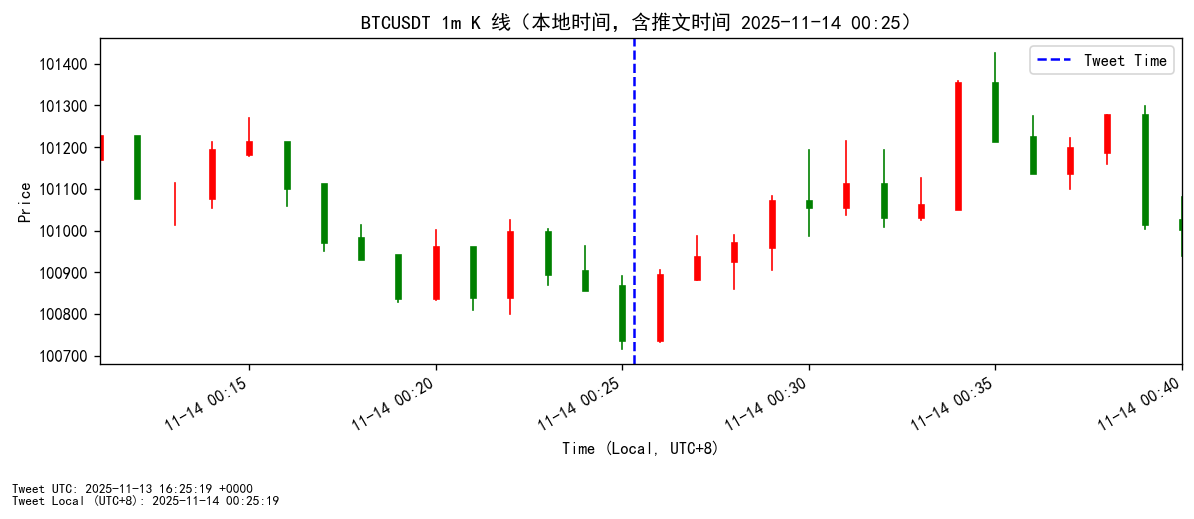

[SUMMARY] {'tweet_id': '1989006673206259821', 'created_at_utc': 'Thu Nov 13 16:25:19 +0000 2025', 'created_at_local': '2025-11-14T00:25:19+00:00', 'symbol': 'BTCUSDT', 'direction': 'long', 'confidence': '45'}


In [25]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(1)

[RUN] 分析 data['tweets'][2]
[TWEET ID   ] 1988965634919821724
[CREATED UTC] Thu Nov 13 13:42:15 +0000 2025
[CREATED CN ] 2025-11-13 21:42:15 (UTC+8)
[TEXT       ] CNB needs some BNB. 🤷‍♂️😆
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [
    "BNB"
  ],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文仅为双关玩笑“CNB needs some BNB”，未出现上所、合作、融资、空投、升级、监管等明确事件，也无明确买入/做空表态与时间点。缺乏可执行的方向性信息，且未提供发布者身份与影响力强弱。属于噪音级情绪，不足以驱动交易，因此选择观望。",
  "预计涨跌幅": "0%-3%",
  "预期消息对市场行情影响的持续时间": "30分钟",
  "消息利好利空强度": "20",
  "原消息": "CNB needs some BNB. 🤷‍♂️😆",
  "消息中文翻译": "CNB需要一些BNB。🤷‍♂️😆",
  "消息置信度": "50"
}
[BASE SYMBOL] BNBUSDT
[SYMBOL     ] BNBUSDT
[DIRECTION  ] 观望
[CONF       ] 50
[INFO] 获取 BNBUSDT 在推文时间前后 15 分钟的 1m K 线…


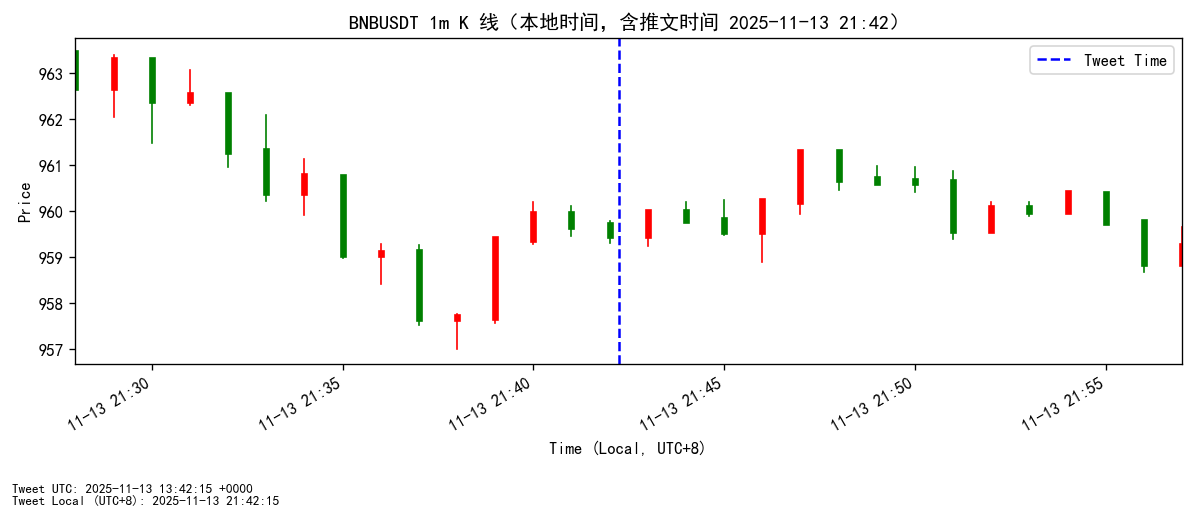

[SUMMARY] {'tweet_id': '1988965634919821724', 'created_at_utc': 'Thu Nov 13 13:42:15 +0000 2025', 'created_at_local': '2025-11-13T21:42:15+00:00', 'symbol': 'BNBUSDT', 'direction': '观望', 'confidence': '50'}


In [26]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(2)、run_analysis(2) 等等
run_analysis(2)

In [27]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(3)

[RUN] 分析 data['tweets'][3]
[TWEET ID   ] 1988883673144336473
[CREATED UTC] Thu Nov 13 08:16:34 +0000 2025
[CREATED CN ] 2025-11-13 16:16:34 (UTC+8)
[TEXT       ] Writing the book made me realize my English is poor, very poor.

Reviewing the Chinese translations by my colleagues made me realize my Chinese is non-existent. Had to use the dictionary constantly.

Basically, I don't really speak any language. 😂
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文内容与加密货币或具体项目无关，没有提到任何币种、上架、合作、融资、空投、升级、黑客、监管或买卖动作，也不存在对某币的看多/看空情绪表态。属于与交易无关的日常吐槽，无法形成事件驱动或情绪驱动的交易信号，故选择观望。",
  "预计涨跌幅": "无",
  "预期消息对市场行情影响的持续时间": "无",
  "消息利好利空强度": "0",
  "原消息": "Writing the book made me realize my English is poor, very poor.\n\nReviewing the Chinese translations by my colleagues made me realize my Chinese is non-existent. Had to use the dictionary constantly.\n\nBasically, I don't really speak any language. 😂",
  "消息中文翻译": "写这本书让我意识到我的英语很差，非常差。审阅同事们的中文翻译让我意识到我根本不会中文，不停查字典。基本上，我

In [28]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(4)

[RUN] 分析 data['tweets'][4]
[TWEET ID   ] 1988882745989153243
[CREATED UTC] Thu Nov 13 08:12:52 +0000 2025
[CREATED CN ] 2025-11-13 16:12:52 (UTC+8)
[TEXT       ] Help me with some arguments? 👇😂
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文内容仅为“Help me with some arguments? 👇😂”，没有提及任何项目、币种、事件或明确的看多/看空表态，也无KOL喊单或可识别的交易信号。根据事件驱动与情绪交易框架，此类内容属于噪音或娱乐互动，无法提炼可操作方向，故观望。",
  "预计涨跌幅": "N/A",
  "预期消息对市场行情影响的持续时间": "N/A",
  "消息利好利空强度": "5",
  "原消息": "Help me with some arguments? 👇😂",
  "消息中文翻译": "帮我提供一些论点？👇😂",
  "消息置信度": "90"
}
[BASE SYMBOL] None
[SYMBOL     ] None
[DIRECTION  ] 观望
[CONF       ] 90
[INFO] 无法确定交易对，视为不可交易，跳过 Binance K 线。
[SUMMARY] {'tweet_id': '1988882745989153243', 'created_at_utc': 'Thu Nov 13 08:12:52 +0000 2025', 'created_at_local': '2025-11-13T16:12:52+00:00', 'symbol': None, 'direction': '观望', 'confidence': '90'}


In [29]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(5)

[RUN] 分析 data['tweets'][5]
[TWEET ID   ] 1988689709045047579
[CREATED UTC] Wed Nov 12 19:25:49 +0000 2025
[CREATED CN ] 2025-11-13 03:25:49 (UTC+8)
[TEXT       ] Our intern tells me that 60% of the comments under my posts are likely AI generated or assisted. Same for Elon Musk's posts.

He used AI to do the analysis...
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文仅讨论社交媒体评论中AI生成内容占比高的现象，没有提及任何具体币种、上所、合作、融资、空投、升级、黑客或监管等事件，也没有KOL对某币种的买入/卖出/看多/看空表态。属于与交易无关的泛讨论信息，缺乏可用于事件驱动或情绪交易的明确标的和方向，因此选择观望。",
  "预计涨跌幅": "—",
  "预期消息对市场行情影响的持续时间": "—",
  "消息利好利空强度": "10",
  "原消息": "Our intern tells me that 60% of the comments under my posts are likely AI generated or assisted. Same for Elon Musk's posts.\n\nHe used AI to do the analysis...",
  "消息中文翻译": "我们的实习生说，我帖子下约60%的评论可能是AI生成或辅助生成的，马斯克的帖子也一样。他是用AI做的这份分析……",
  "消息置信度": "70"
}
[BASE SYMBOL] None
[SYMBOL     ] None
[DIRECTION  ] 观望
[CONF       ] 70
[INFO] 无法确定交易对，视为不可交易，跳过 Binance K 线。
[SUMMARY] {'tweet_id': '1

In [30]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(6)

[RUN] 分析 data['tweets'][6]
[TWEET ID   ] 1988519142819872810
[CREATED UTC] Wed Nov 12 08:08:03 +0000 2025
[CREATED CN ] 2025-11-12 16:08:03 (UTC+8)
[TEXT       ] RT @eleanorshughes1: Glad to see the Ontario Court of Appeal set aside an Ontario Securities Commission document demand it described as “st…
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文内容涉及安大略省上诉法院对安省证券委员会（OSC）的一份文件要求作出撤销的法律程序性进展，未提及任何加密项目或币种、未出现上所/合作/融资/升级/安全事件/监管明确利好或利空针对某币的细节，也无KOL对特定币种的看多或看空喊单。该信息与加密市场的直接交易标的关联度极低，缺乏可执行的方向性信号，属于与交易无关或高度间接的监管法律动态，故给出观望。",
  "预计涨跌幅": "不适用",
  "预期消息对市场行情影响的持续时间": "不适用",
  "消息利好利空强度": "10",
  "原消息": "RT @eleanorshughes1: Glad to see the Ontario Court of Appeal set aside an Ontario Securities Commission document demand it described as “st…",
  "消息中文翻译": "转推 @eleanorshughes1：很高兴看到安大略省上诉法院撤销了一份安省证券委员会（OSC）的文件要求，并将其描述为“st…（内容被截断）”。",
  "消息置信度": "45"
}
[BASE SYMBOL] None
[SYMBOL     ] None
[DIRECTION  ] 观望
[CONF       ] 45
[INFO] 无法确定交易对，视为不可交易，跳过 Binance

In [31]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(7)

[RUN] 分析 data['tweets'][7]
[TWEET ID   ] 1988216302952124890
[CREATED UTC] Tue Nov 11 12:04:40 +0000 2025
[CREATED CN ] 2025-11-11 20:04:40 (UTC+8)
[TEXT       ] This is NOT my book. Beware of scammers using AI to make fake books. 🤣 https://t.co/FXcHKbGf5O
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文仅为个人澄清“有人用AI伪造书籍与其无关”，与任何加密项目或币种无直接关联，无上所/合作/融资/链上变更/监管/黑客等事件，也无对任一币种的看多或看空表态。属于与交易无关的信息噪音，缺乏可触发情绪交易的标的与方向，因此选择观望。",
  "预计涨跌幅": "0%-2%",
  "预期消息对市场行情影响的持续时间": "30分钟",
  "消息利好利空强度": "5",
  "原消息": "This is NOT my book. Beware of scammers using AI to make fake books. 🤣 https://t.co/FXcHKbGf5O",
  "消息中文翻译": "这不是我的书。小心骗子用AI伪造书籍。🤣",
  "消息置信度": "85"
}
[BASE SYMBOL] None
[SYMBOL     ] None
[DIRECTION  ] 观望
[CONF       ] 85
[INFO] 无法确定交易对，视为不可交易，跳过 Binance K 线。
[SUMMARY] {'tweet_id': '1988216302952124890', 'created_at_utc': 'Tue Nov 11 12:04:40 +0000 2025', 'created_at_local': '2025-11-11T20:04:40+00:00', 'symbol': None, 'direction': '观望', 'confidence': '8

In [32]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(8)

[RUN] 分析 data['tweets'][8]
[TWEET ID   ] 1988110086280253660
[CREATED UTC] Tue Nov 11 05:02:36 +0000 2025
[CREATED CN ] 2025-11-11 13:02:36 (UTC+8)
[TEXT       ] RT @binance: Introducing Crypto Trade Analyzer! 

Compare real-time trading costs across top exchanges. Customize fees &amp; spot your cost-eff…
[AI RAW]
{
  "分析结果": "市场整体利好",
  "交易币种": ["BNB","BTC","ETH"],
  "交易方向": "long",
  "是否基于图片": "否",
  "分析依据": "推文为来自 Binance 官方账号的转推，内容是推出“Crypto Trade Analyzer”工具，用于比较各大交易所的实时交易成本。事件属性为产品上线/功能发布，来自头部交易所官方账号，属高影响力信息。此类工具有助于降低用户交易摩擦、提升活跃度与成交量，短线对交易所相关情绪偏多，间接利好主流大盘与BNB生态。虽然非上币级别硬利好，但作为头部平台功能迭代，短线情绪改善可带来小幅风险偏好回升。因此给出轻仓情绪驱动的long思路，标的以BNB为主，同时兼顾大盘情绪的BTC、ETH。",
  "预计涨跌幅": "2%-6%",
  "预期消息对市场行情影响的持续时间": "数小时",
  "消息利好利空强度": "55",
  "原消息": "RT @binance: Introducing Crypto Trade Analyzer! \n\nCompare real-time trading costs across top exchanges. Customize fees & spot your cost-eff…",
  "消息中文翻译": "转推自币安：推出“加密交易分析器”！可比较各大交易所的实时交易成本，自定义费用并发现你的成本效率……",
  "消息置信度": "85",
  "入场思路": "情绪利好为主，非硬性上币事件。建议轻仓，

[RUN] 分析 data['tweets'][9]
[TWEET ID   ] 1987881995402113260
[CREATED UTC] Mon Nov 10 13:56:15 +0000 2025
[CREATED CN ] 2025-11-10 21:56:15 (UTC+8)
[TEXT       ] #BNB
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [
    "BNB"
  ],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "原始推文仅有标签#BNB，没有任何事件信息、KOL喊单、买卖动作或时间指引。无法确认是否存在上所、合作、融资、链上升级、监管或黑客等事件，也没有看到有影响力账户的明确看多/看空表态。属于极度模糊的信息噪音，不具备事件驱动或情绪驱动的交易价值，因此选择观望。",
  "预计涨跌幅": "不适用",
  "预期消息对市场行情影响的持续时间": "不适用",
  "消息利好利空强度": "0",
  "原消息": "#BNB",
  "消息中文翻译": "#BNB（仅话题标签，无其他内容）",
  "消息置信度": "30"
}
[BASE SYMBOL] BNBUSDT
[SYMBOL     ] BNBUSDT
[DIRECTION  ] 观望
[CONF       ] 30
[INFO] 获取 BNBUSDT 在推文时间前后 15 分钟的 1m K 线…


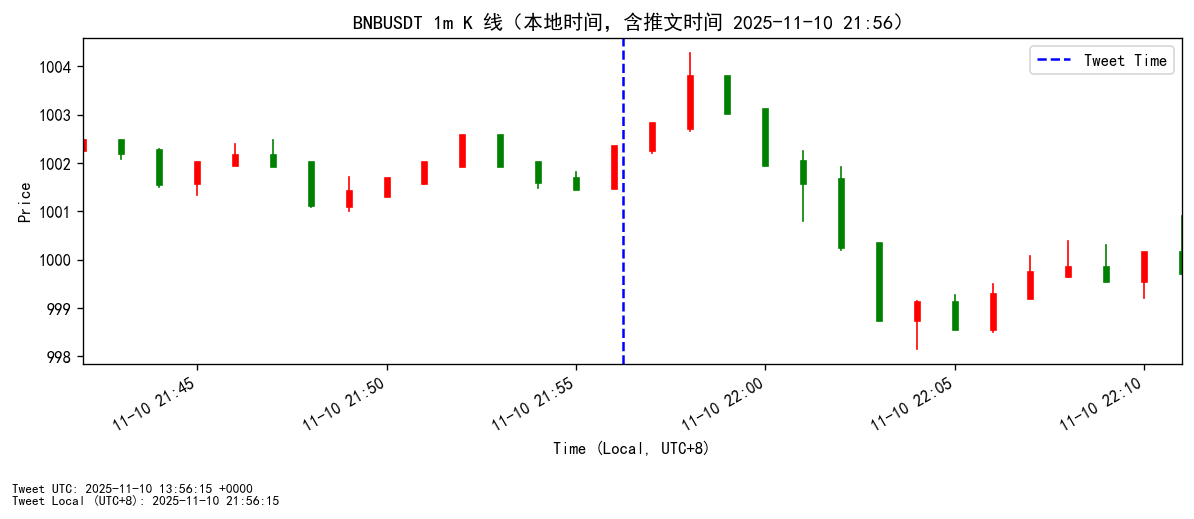

[SUMMARY] {'tweet_id': '1987881995402113260', 'created_at_utc': 'Mon Nov 10 13:56:15 +0000 2025', 'created_at_local': '2025-11-10T21:56:15+00:00', 'symbol': 'BNBUSDT', 'direction': '观望', 'confidence': '30'}


In [33]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(9)

[RUN] 分析 data['tweets'][10]
[TWEET ID   ] 1987875167780118728
[CREATED UTC] Mon Nov 10 13:29:07 +0000 2025
[CREATED CN ] 2025-11-10 21:29:07 (UTC+8)
[TEXT       ] I might have contributed a tiny bit to Kazakhstan's launching of $1 billion crypto reserve fund. 😆
 https://t.co/vquLAjmL72
[AI JSON]
{
  "分析结果": "市场整体利好",
  "交易币种": [
    "BTC",
    "ETH",
    "SOL"
  ],
  "交易方向": "long",
  "是否基于图片": "否",
  "分析依据": "推文称哈萨克斯坦将启动10亿美元加密储备基金，属于主权层面的资金入场和潜在监管友好信号，偏事件利好；尽管推文口吻略带玩笑，但核心信息为国家级资金配置意向，属于宏观资金面利好，对整体市场情绪正向。未指向单一币种，优先选择高流动性主流标的进行事件驱动的情绪交易。由于消息源为个人推文，落地细节与官方确认度有限，采取短线偏多思路但控制仓位与风险。",
  "预计涨跌幅": "3%-8%",
  "预期消息对市场行情影响的持续时间": "数小时",
  "消息利好利空强度": "60",
  "原消息": "I might have contributed a tiny bit to Kazakhstan's launching of $1 billion crypto reserve fund. 😆\n https://t.co/vquLAjmL72",
  "消息中文翻译": "我可能对哈萨克斯坦启动10亿美元加密储备基金略有贡献。😆",
  "消息置信度": "55"
}
[BASE SYMBOL] BTCUSDT
[SYMBOL     ] BTCUSDT
[DIRECTION  ] long
[CONF       ] 55
[INFO] 获取 BTCUSDT 在推文时间前后 15 分钟的 1m K 线…


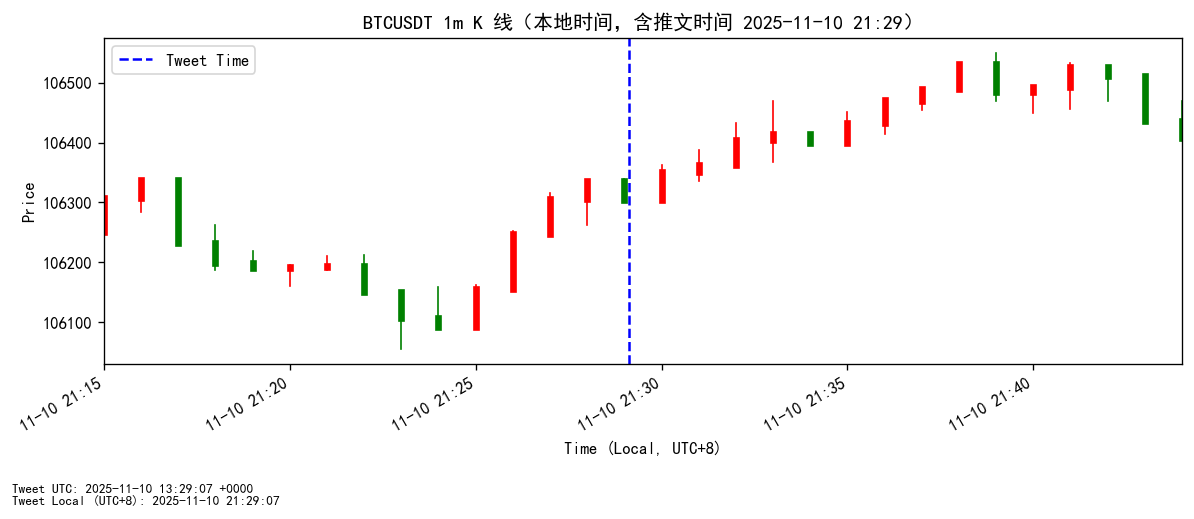

[SUMMARY] {'tweet_id': '1987875167780118728', 'created_at_utc': 'Mon Nov 10 13:29:07 +0000 2025', 'created_at_local': '2025-11-10T21:29:07+00:00', 'symbol': 'BTCUSDT', 'direction': 'long', 'confidence': '55'}


In [34]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(10)

In [35]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(11)

[RUN] 分析 data['tweets'][11]
[TWEET ID   ] 1987786698538012685
[CREATED UTC] Mon Nov 10 07:37:34 +0000 2025
[CREATED CN ] 2025-11-10 15:37:34 (UTC+8)
[TEXT       ] Don't buy handles that I follow. I will unfollow any sold accounts. If you see an account for sale, let me know. DM, tweet, notify "interns".

I follow accounts "randomly", usually supportive, informative, positive energy people.

My follow means nothing, not endorsement.
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "该推文没有提及任何具体项目或币种，也无上所、合作、融资、升级、黑客、监管等事件，更无明确的买入/卖出/做多/做空表态。内容核心是KOL澄清其关注不代表背书，并表示会取关被售卖的账号，实质为去关联、降预期的声明，属于情绪中性偏淡化影响的信号。因缺乏可落实到具体标的的事件驱动或情绪喊单，不宜给出方向性交易建议，选择观望。",
  "预计涨跌幅": "0%-2%",
  "预期消息对市场行情影响的持续时间": "数小时",
  "消息利好利空强度": "10",
  "原消息": "Don't buy handles that I follow. I will unfollow any sold accounts. If you see an account for sale, let me know. DM, tweet, notify \"interns\".\n\nI follow accounts \"randomly\", usually supportive, informative, positive energy people.\n

In [36]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(12)

[RUN] 分析 data['tweets'][12]
[TWEET ID   ] 1987497485401780261
[CREATED UTC] Sun Nov 09 12:28:21 +0000 2025
[CREATED CN ] 2025-11-09 20:28:21 (UTC+8)
[TEXT       ] Nothing much. I unfollow mostly inactive accounts once in a while. 🤷‍♂️😂
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文仅表示作者会不时取关不活跃账户，未涉及任何项目、币种、事件或明确的看多/看空表态。无上所、合作、融资、空投、升级、监管、黑客等事件信息，也无KOL对特定币种的买入/卖出喊单。属于与交易无关的日常内容，按事件驱动与情绪交易框架应选择观望。",
  "预计涨跌幅": "0%",
  "预期消息对市场行情影响的持续时间": "无",
  "消息利好利空强度": "0",
  "原消息": "Nothing much. I unfollow mostly inactive accounts once in a while. 🤷‍♂️😂",
  "消息中文翻译": "没啥特别的。我偶尔会取消关注大多不活跃的账号。🤷‍♂️😂",
  "消息置信度": "90"
}
[BASE SYMBOL] None
[SYMBOL     ] None
[DIRECTION  ] 观望
[CONF       ] 90
[INFO] 无法确定交易对，视为不可交易，跳过 Binance K 线。
[SUMMARY] {'tweet_id': '1987497485401780261', 'created_at_utc': 'Sun Nov 09 12:28:21 +0000 2025', 'created_at_local': '2025-11-09T20:28:21+00:00', 'symbol': None, 'direction': '观望', 'confidence': '90'}


In [37]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(13)

[RUN] 分析 data['tweets'][13]
[TWEET ID   ] 1987480267884318963
[CREATED UTC] Sun Nov 09 11:19:56 +0000 2025
[CREATED CN ] 2025-11-09 19:19:56 (UTC+8)
[TEXT       ] RT @joyhodling: Who owes the United States and other countries debt?

How does the system operate?

Who is believed to have designed or inf…
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "该推文内容是对宏观债务与系统设计的提问式转发，未提及任何加密项目、币种、交易所、合作、融资、链上变更或监管等具体事件，也无KOL对特定币种的明确看多/看空或买卖动作。属于与交易无关的泛宏观讨论，不具备事件驱动或情绪喊单的交易信号，因此选择观望。",
  "预计涨跌幅": "不适用",
  "预期消息对市场行情影响的持续时间": "不适用",
  "消息利好利空强度": "5",
  "原消息": "RT @joyhodling: Who owes the United States and other countries debt?\n\nHow does the system operate?\n\nWho is believed to have designed or inf…",
  "消息中文翻译": "转推 @joyhodling：谁欠了美国和其他国家的债？这个系统如何运转？谁被认为设计或影响了它……",
  "消息置信度": "85"
}
[BASE SYMBOL] None
[SYMBOL     ] None
[DIRECTION  ] 观望
[CONF       ] 85
[INFO] 无法确定交易对，视为不可交易，跳过 Binance K 线。
[SUMMARY] {'tweet_id': '1987480267884318963', 'created_at_utc': 'Sun

[RUN] 分析 data['tweets'][14]
[TWEET ID   ] 1987454778650300870
[CREATED UTC] Sun Nov 09 09:38:39 +0000 2025
[CREATED CN ] 2025-11-09 17:38:39 (UTC+8)
[TEXT       ] Just cleaning up the wallet. The donation address only keeps #BNB. Next time, I might choose to market sell any meme coins received.

Do not send tokens to the address if you don't want them to be sold on the market
[AI JSON]
{
  "分析结果": "特定币种利空",
  "交易币种": [
    "BNB",
    "各类meme币（泛指空投到该地址的代币）"
  ],
  "交易方向": "short",
  "是否基于图片": "否",
  "分析依据": "推文核心为影响力账户声明其公开捐赠地址仅保留BNB，未来接收到的任意meme币将可能直接市价卖出，并警告不要再发送代币以免被抛售。这构成两个层面的事件驱动与情绪影响：1) 对被其地址收到的meme币是直接供给侧的抛压威胁，属于短线利空；2) 侧面表态“不接盘meme”，对meme板块情绪有负面扩散。对BNB本身为中性/略正面（不卖BNB），但主信息是“卖出meme”，因此给出对meme币的短线做空思路。由于未指向单一meme标的，策略更偏向事件情绪驱动、以跟踪该地址链上动作为触发。",
  "预计涨跌幅": "5%-15%",
  "预期消息对市场行情影响的持续时间": "数小时",
  "消息利好利空强度": "62",
  "原消息": "Just cleaning up the wallet. The donation address only keeps #BNB. Next time, I might choose to market sell any meme coins received.\n\nDo not send tokens to the

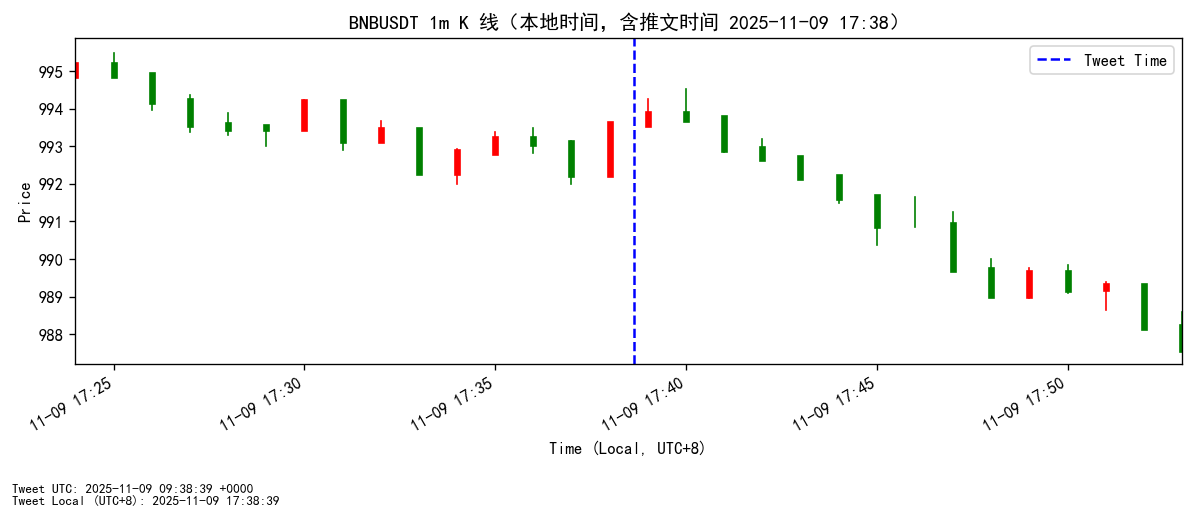

[SUMMARY] {'tweet_id': '1987454778650300870', 'created_at_utc': 'Sun Nov 09 09:38:39 +0000 2025', 'created_at_local': '2025-11-09T17:38:39+00:00', 'symbol': 'BNBUSDT', 'direction': 'short', 'confidence': '70'}


In [38]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(14)

In [39]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(15)

[RUN] 分析 data['tweets'][15]
[TWEET ID   ] 1987429930037309496
[CREATED UTC] Sun Nov 09 07:59:54 +0000 2025
[CREATED CN ] 2025-11-09 15:59:54 (UTC+8)
[TEXT       ] I once saw on a t-shirt (from my first day in college, at orientation, 30 years ago) 🤣:

It's hard to be good; It's good to be hard.
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "该推文仅为玩笑/段子性质，没有提及任何加密项目、币种、交易所、买卖动作或事件信息，也无KOL对某币的明确看多/看空表态。缺乏事件驱动与情绪喊单信号，属于与交易无关内容，按策略应观望。",
  "预计涨跌幅": "不适用",
  "预期消息对市场行情影响的持续时间": "不适用",
  "消息利好利空强度": "0",
  "原消息": "I once saw on a t-shirt (from my first day in college, at orientation, 30 years ago) 🤣:\n\nIt's hard to be good; It's good to be hard.",
  "消息中文翻译": "我在30年前大学新生入学时看到过一件T恤上的话：\"做好人很难；硬起来就很好。\"（玩笑/段子）",
  "消息置信度": "95"
}
[BASE SYMBOL] None
[SYMBOL     ] None
[DIRECTION  ] 观望
[CONF       ] 95
[INFO] 无法确定交易对，视为不可交易，跳过 Binance K 线。
[SUMMARY] {'tweet_id': '1987429930037309496', 'created_at_utc': 'Sun Nov 09 07:59:54 +0000 2025', 'created_at_local': '

[RUN] 分析 data['tweets'][16]
[TWEET ID   ] 1987427871347122431
[CREATED UTC] Sun Nov 09 07:51:43 +0000 2025
[CREATED CN ] 2025-11-09 15:51:43 (UTC+8)
[TEXT       ] In my advisor role to governments, last week, two senior officials from two different countries referred to crypto as "the hard money". The realization is finally happening. 💪
[AI JSON]
{
  "分析结果": "市场整体利好",
  "交易币种": [
    "BTC",
    "ETH",
    "SOL"
  ],
  "交易方向": "long",
  "是否基于图片": "否",
  "分析依据": "推文来自具备政府顾问身份的KOL，称两国高级官员将加密货币视为“硬通货”，属于政策层面态度转向的正面信号。虽无具体政策落地或单一币种点名，但对市场整体风险偏好与叙事具有提振作用，典型情绪驱动型利好。由于未出现具体上市、合作、监管放宽等落地事件，强度不及硬事件，但考虑KOL身份与“政府高层认知转变”的稀缺性，短线有望引发主流币情绪拉升与资金跟随，故给出市场整体轻仓long思路，重点放在高流动性主流币以承接情绪。",
  "预计涨跌幅": "2%-6%",
  "预期消息对市场行情影响的持续时间": "数小时",
  "消息利好利空强度": "48",
  "原消息": "In my advisor role to governments, last week, two senior officials from two different countries referred to crypto as \"the hard money\". The realization is finally happening. 💪",
  "消息中文翻译": "在我担任政府顾问的角色中，上周来自两个不同国家的两位高级官员把加密货币称为“硬通货”。这种认知终于在发生。

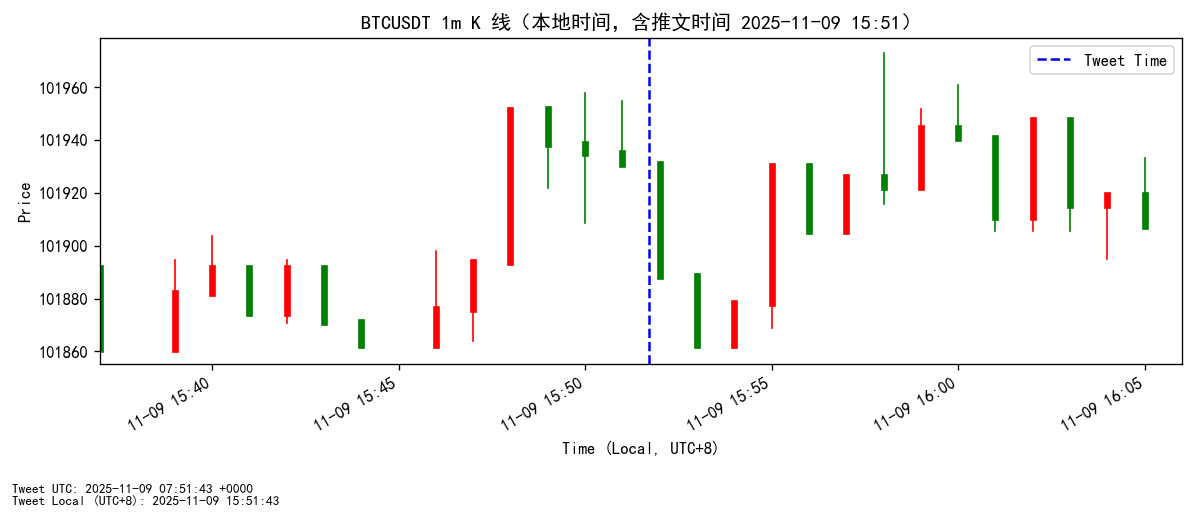

[SUMMARY] {'tweet_id': '1987427871347122431', 'created_at_utc': 'Sun Nov 09 07:51:43 +0000 2025', 'created_at_local': '2025-11-09T15:51:43+00:00', 'symbol': 'BTCUSDT', 'direction': 'long', 'confidence': '60'}


In [40]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(16)

In [41]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(17)

[RUN] 分析 data['tweets'][17]
[TWEET ID   ] 1987197598021881984
[CREATED UTC] Sat Nov 08 16:36:42 +0000 2025
[CREATED CN ] 2025-11-09 00:36:42 (UTC+8)
[TEXT       ] Spent the last couple of weeks running through the final edits on my book/memoir. Nearly done. Need a cover design. Any suggestions? 👇
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文仅为个人近况更新：作者在处理其书籍/回忆录的最终编辑并寻求封面设计建议。未涉及任何加密项目、币种、交易所、买入/卖出/看多/看空等行为，也无上所、合作、融资、升级、监管等事件。属于与加密市场无关的信息，不具备事件驱动或情绪喊单属性，无法据此给出方向性交易建议。",
  "预计涨跌幅": "0%",
  "预期消息对市场行情影响的持续时间": "无",
  "消息利好利空强度": "0",
  "原消息": "Spent the last couple of weeks running through the final edits on my book/memoir. Nearly done. Need a cover design. Any suggestions? 👇",
  "消息中文翻译": "过去几周我一直在完成我的书/回忆录的最终修改。快完成了。需要一个封面设计。有任何建议吗？",
  "消息置信度": "90"
}
[BASE SYMBOL] None
[SYMBOL     ] None
[DIRECTION  ] 观望
[CONF       ] 90
[INFO] 无法确定交易对，视为不可交易，跳过 Binance K 线。
[SUMMARY] {'tweet_id': '1987197598021881984', 'created_at_utc': 'Sat Nov 08 16:36:4

In [42]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(18)

[RUN] 分析 data['tweets'][18]
[TWEET ID   ] 1987127569695842625
[CREATED UTC] Sat Nov 08 11:58:26 +0000 2025
[CREATED CN ] 2025-11-08 19:58:26 (UTC+8)
[TEXT       ] Did you know you can create your own storybooks for your kids on @GiggleAcademy?
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文仅为关于在 @GiggleAcademy 上给孩子创建故事书的功能介绍，未提及任何加密项目代币、上所、合作、融资、空投、主网升级、监管或买卖行为，也不存在KOL对某币的明确看多/看空喊单。缺乏可交易的标的与事件驱动，属于与加密交易无关的信息噪音，因此选择观望。",
  "预计涨跌幅": "0%",
  "预期消息对市场行情影响的持续时间": "无",
  "消息利好利空强度": "5",
  "原消息": "Did you know you can create your own storybooks for your kids on @GiggleAcademy?",
  "消息中文翻译": "你知道你可以在 @GiggleAcademy 为你的孩子创建自己的故事书吗？",
  "消息置信度": "85"
}
[BASE SYMBOL] None
[SYMBOL     ] None
[DIRECTION  ] 观望
[CONF       ] 85
[INFO] 无法确定交易对，视为不可交易，跳过 Binance K 线。
[SUMMARY] {'tweet_id': '1987127569695842625', 'created_at_utc': 'Sat Nov 08 11:58:26 +0000 2025', 'created_at_local': '2025-11-08T19:58:26+00:00', 'symbol': None, 'direction': '观望', 'confidence': '

In [49]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(19)

[RUN] 分析 data['tweets'][19]
[TWEET ID   ] 1987069115698454734
[CREATED UTC] Sat Nov 08 08:06:09 +0000 2025
[CREATED CN ] 2025-11-08 16:06:09 (UTC+8)
[TEXT       ] Busy week in Abu Dhabi/Dubai in early Dec. BBW (#Binance Blockchain Week) happening earlier in the week on Dec 3-4 too. Plus F1.

Yes, I promote all conferences. No competition in pushing adoption.
[AI JSON]
{
  "分析结果": "观望",
  "交易币种": [],
  "交易方向": "观望",
  "是否基于图片": "否",
  "分析依据": "推文仅提到12月初在阿布扎比/迪拜有会议（Binance Blockchain Week）和F1，并强调自己推广所有会议、推动采用。没有提及任何具体币种、上所、合作、融资、空投、技术升级或买卖方向，也无明确KOL对某币的看多/看空表态。属于一般性行业活动信息，偏情绪中性，缺乏可交易的明确事件驱动或喊单信号，因此选择观望。",
  "预计涨跌幅": "—",
  "预期消息对市场行情影响的持续时间": "—",
  "消息利好利空强度": "20",
  "原消息": "Busy week in Abu Dhabi/Dubai in early Dec. BBW (#Binance Blockchain Week) happening earlier in the week on Dec 3-4 too. Plus F1.\n\nYes, I promote all conferences. No competition in pushing adoption.",
  "消息中文翻译": "12月初在阿布扎比/迪拜会很忙。#Binance Blockchain Week 将在12月3-4日举行，还有F1。\n是的，我推广所有会议。在推动采用方面没有竞争。",
  "消息置信度": "85"

In [1]:
# 示例：运行第 0 条推文
from twitter_crawler_functional_min import ai_analyze_text, LOCAL_JSON_PATH
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(0, json_path="./twitter_media/1984992347395141987.json")

[INIT] 配置与显示初始化完成


NameError: name 'run_analysis' is not defined